In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
from matplotlib import pyplot as plt

In [2]:
df_old = pd.read_csv(
    "data_hpo-method-validation_2023-02-28_10-35.csv",
    encoding="utf_16_le",
    delimiter=";",
).drop(columns="DEG_TIME")
df_old.shape

(152, 443)

In [3]:
df_new = pd.read_csv(
    "data_hpo-motives_2025-02-05_22-10.csv",
    encoding="utf_16_le",
    delimiter=";",
).drop(columns="STATUS")

for column in set(df_old.columns.tolist()) - set(df_new.columns.tolist()):
    df_new[column] = np.nan

for column in df_old.columns:
    if (df_old[column].dtype) == "O":
        df_new[column] = df_new[column].apply(str)

df_new.shape

(26, 457)

In [4]:
df = pd.concat((df_old, df_new)).reset_index(drop=True)
df.shape

(178, 457)

# Goal - Methods

In [5]:
df_all = (
    df.where(
        (df["MAXPAGE"] == "3")
        | (df["MAXPAGE"] == "4")
        | (df["MAXPAGE"] == "5")
        | (df["MAXPAGE"] == "Letzte Seite, die im Fragebogen bearbeitet wurde")
    )
    .dropna(subset=["MAXPAGE"])
    .copy()
)

In [6]:
df_all = df_all.replace("/Another HPO Method", "/Evolutionary Algorithm", regex=True)
df_all = df_all.replace("Model Comprehension", "ML Model Understanding", regex=True)

In [7]:
# select only answers relating to the first question (Which of the following goals did you try to reach by using HPO?)
df_go01 = df_all.filter(regex=("^GO01"))

# select only answers relating to the second question (Which of the following goals did you successfully attain by using HPO?)
df_go02 = df_all.filter(regex=("^GO02"))

## Number of Participants who have used a certain method

In [8]:
# create data frame summarizing all answers to the GD01 listing methods, goal, participant id and selection

goal_method = []
for index, column in enumerate(df_go01.columns):
    row = {}

    # extract the method
    item_description = df_go01[column][0]
    method = re.findall("([^/]+$)", item_description)[0]
    goal = re.findall(":\s(.*):", item_description)[0]
    value = df_go01[column].drop(0).apply(lambda x: 1 if x == "ausgewählt" else 0)

    if index % 6 == 0:
        method = "I did not try to reach the goal"
        goal = re.search(":\s(.*):\s(.*):", item_description)
        goal = goal.group(2)
        value = (
            df_go01[column]
            .drop(0)
            .apply(lambda x: 1 if x == r"I did not try to reach this goal." else 0)
        )

    for entry in value.items():
        row = {
            "method": method,
            "goal": goal,
            "participant": entry[0],
            "selection": entry[1],
        }
        goal_method.append(row)

df_goal_method = pd.DataFrame(goal_method)

<>:10: SyntaxWarning: invalid escape sequence '\s'
<>:15: SyntaxWarning: invalid escape sequence '\s'
<>:10: SyntaxWarning: invalid escape sequence '\s'
<>:15: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Marc\AppData\Local\Temp\ipykernel_18532\707748001.py:10: SyntaxWarning: invalid escape sequence '\s'
  goal = re.findall(":\s(.*):", item_description)[0]
C:\Users\Marc\AppData\Local\Temp\ipykernel_18532\707748001.py:15: SyntaxWarning: invalid escape sequence '\s'
  goal = re.search(":\s(.*):\s(.*):", item_description)


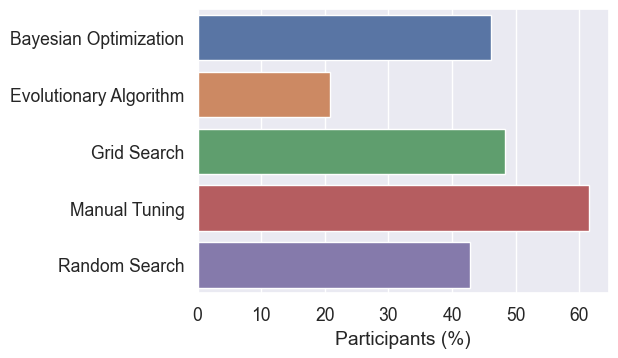

In [9]:
sns.set_theme(font_scale=1.15)

plt.figure(figsize=(6.4, 3.8))
seaborn_method_count = (
    df_goal_method[df_goal_method["selection"] == 1]
    .groupby("method")["participant"]
    .nunique()
    .drop("I did not try to reach the goal")
)
ax = sns.barplot(
    (
        seaborn_method_count * 100 / df_goal_method["participant"].nunique()
    ).reset_index(),
    x="participant",
    y="method",
    hue="method",
)
ax.set_ylabel(None)
ax.set_xlabel("Participants (%)")

plt.tight_layout()
plt.savefig("figs/participant_method_usage_percentage.pdf")
plt.show()

In [10]:
df_goal_method["participant"].nunique()

91

C:\Users\Marc\AppData\Local\Temp\ipykernel_18532\358579083.py:14: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  ax = sns.barplot(


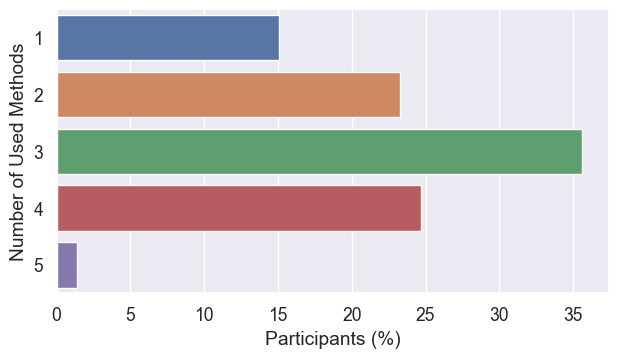

In [11]:
tmp = (
    df_goal_method[
        (df_goal_method["selection"] == 1)
        & (df_goal_method["method"] != "I did not try to reach the goal")
    ]
    .groupby(["participant", "method"])
    .nunique()
    .reset_index()[["participant", "method"]]
)
tmp = tmp.groupby("participant").count().value_counts().reset_index()
tmp["participants"] = tmp["count"] * 100 / tmp["count"].sum()

plt.figure(figsize=(6.4, 3.8))
ax = sns.barplot(
    tmp,
    x="participants",
    y="method",
    hue="method",
    legend=False,
    orient="h",
    palette=sns.color_palette(),
)
ax.set_xlabel("Participants (%)")
ax.set_ylabel("Number of Used Methods")

plt.tight_layout()
plt.savefig("figs/multiple_hpo_methods.pdf")
plt.show()

## Pursued Goals

In [12]:
# define method to create heatmap counting all occurences of method combinations


def create_2d_matrix(df):
    heatmap = []

    for index, column in enumerate(df.columns):
        # extract the method
        item_description = df[column][0]
        method = re.findall("([^/]+$)", item_description)[0]
        goal = re.findall(":\s(.*):", item_description)[0]

        count = df[column].str.contains(r"ausgewählt").sum()

        if index % 6 == 0:
            method = "I did not try to reach the goal"
            goal = re.search(":\s(.*):\s(.*):", item_description)
            goal = goal.group(2)
            count = df[column].str.contains(r"I did not try to reach this goal.").sum()

        row = {"method": method, "goal": goal, "count": count}

        heatmap.append(row)

    df_heatmap = pd.DataFrame(heatmap)

    return df_heatmap.pivot(index="method", columns="goal", values="count")


<>:11: SyntaxWarning: invalid escape sequence '\s'
<>:17: SyntaxWarning: invalid escape sequence '\s'
<>:11: SyntaxWarning: invalid escape sequence '\s'
<>:17: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Marc\AppData\Local\Temp\ipykernel_18532\2456898749.py:11: SyntaxWarning: invalid escape sequence '\s'
  goal = re.findall(":\s(.*):", item_description)[0]
C:\Users\Marc\AppData\Local\Temp\ipykernel_18532\2456898749.py:17: SyntaxWarning: invalid escape sequence '\s'
  goal = re.search(":\s(.*):\s(.*):", item_description)


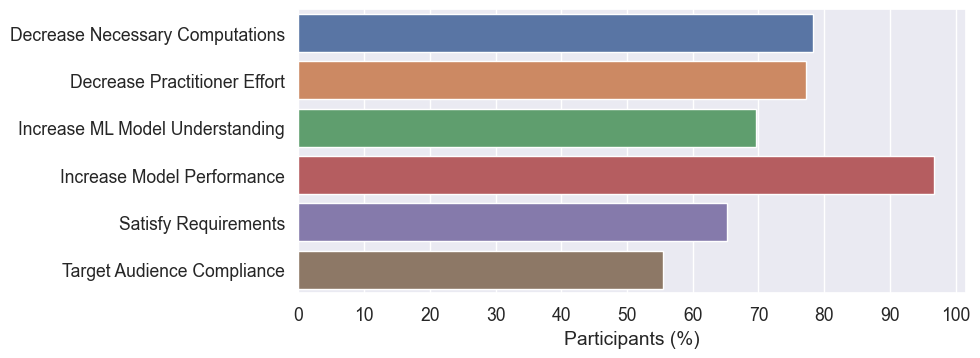

In [13]:
pursued_goals = create_2d_matrix(df_go01)

pursued_goals = (
    1 - pursued_goals.loc["I did not try to reach the goal"] / df_go01.shape[0]
).reset_index()
pursued_goals["I did not try to reach the goal"] = (
    pursued_goals["I did not try to reach the goal"] * 100
)

plt.figure(figsize=(10, 3.8))
ax = sns.barplot(
    pursued_goals, x="I did not try to reach the goal", y="goal", hue="goal"
)
ax.set_xlabel("Participants (%)")
ax.set_ylabel(None)
ax.set_xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])

plt.tight_layout()
plt.savefig("figs/pursued_goals.pdf")
plt.show()

## Goal Method Heatmap

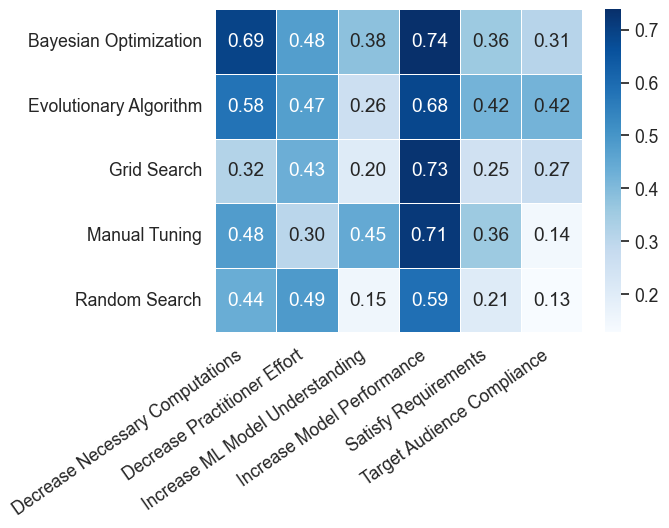

In [14]:
hm = (
    create_2d_matrix(df_go01)
    .drop(index="I did not try to reach the goal")
    .divide(seaborn_method_count, axis="rows")
)

plt.figure(figsize=(7, 5.5))
ax = sns.heatmap(hm, annot=True, cmap="Blues", linewidth=0.5, fmt=".2f")
ax.set_xlabel(None)
ax.set_ylabel(None)
plt.xticks(rotation=35, ha="right")

plt.tight_layout()
plt.savefig("figs/attempted_goal_method_matrix.pdf")
plt.show()

### Correcting survey tool

In [15]:
tried = df_go01.where(df_go01 == "ausgewählt").replace({"ausgewählt": 1})
tried = tried.fillna(0)

success = df_go02.where(df_go02 == "ausgewählt").replace({"ausgewählt": 1})
success = success.fillna(0)

res = success[success > tried.values].dropna(how="all")

C:\Users\Marc\AppData\Local\Temp\ipykernel_18532\2336808521.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tried = df_go01.where(df_go01 == "ausgewählt").replace({"ausgewählt": 1})
C:\Users\Marc\AppData\Local\Temp\ipykernel_18532\2336808521.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  success = df_go02.where(df_go02 == "ausgewählt").replace({"ausgewählt": 1})


In [16]:
cell_locations = []
for i in range(len(res)):
    for j in range(len(res.columns)):
        if res.iloc[i, j] == 1:
            cell_locations.append((res.index[i], res.columns[j]))

In [17]:
for location in cell_locations:
    df_go02.at[location[0], location[1]] = "nicht gewählt"

## Self Reported Successrate

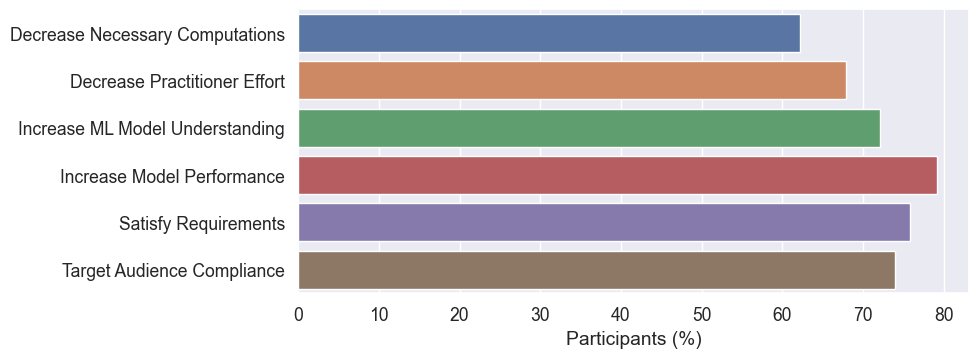

In [18]:
count = create_2d_matrix(df_go01).drop(index="I did not try to reach the goal")
weights = count / count.sum()

success = create_2d_matrix(df_go02).drop("I did not try to reach the goal")
(success / count).sum().reset_index()
tmp = (success / count * weights).sum().reset_index()
tmp[0] *= 100

plt.figure(figsize=(10, 3.8))
ax = sns.barplot(tmp, x=0, y="goal", hue="goal")
ax.set_ylabel(None)
ax.set_xlabel("Participants (%)")

plt.tight_layout()
plt.savefig("figs/sucess_rate_per_goal.pdf")
plt.show()


In [19]:
(success / count * weights).sum().reset_index()

,goal,0
0,Decrease Necessary Computations,0.622449
1,Decrease Practitioner Effort,0.678571
2,Increase ML Model Understanding,0.721311
3,Increase Model Performance,0.791367
4,Satisfy Requirements,0.758065
5,Target Audience Compliance,0.739130


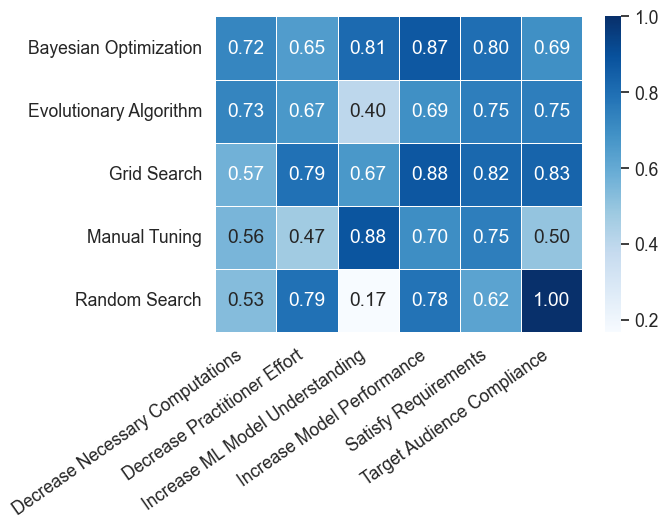

In [20]:
plt.figure(figsize=(7, 5.5))
ax = sns.heatmap(
    (create_2d_matrix(df_go02) / create_2d_matrix(df_go01)).drop(
        "I did not try to reach the goal"
    ),
    annot=True,
    cmap="Blues",
    linewidth=0.5,
    fmt=".2f",
)
ax.set_xlabel(None)
ax.set_ylabel(None)
plt.xticks(rotation=35, ha="right")

plt.tight_layout()
plt.savefig("figs/self_reported_success_rate_heatmap.pdf")
plt.show()


# Decision Factors

In [21]:
map = {
    "I did not consider this decision factor.": np.nan,
    "Very Low": -2,
    "Low": -1,
    "Neutral": 0,
    "High": 1,
    "Very High": 2,
}

In [22]:
df_decision_factors = (
    df.where(
        (df["MAXPAGE"] == "4")
        | (df["MAXPAGE"] == "5")
        | (df["MAXPAGE"] == "Letzte Seite, die im Fragebogen bearbeitet wurde")
    )
    .dropna(subset=["MAXPAGE"])
    .replace(map)
)

df_decision_factors.shape

C:\Users\Marc\AppData\Local\Temp\ipykernel_18532\1086675249.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace(map)


(60, 457)

## Percentage I did consider this decision factor

In [23]:
rows = []
for j in range(1, 15):
    description_string = (
        df_decision_factors.filter(regex=(f"^GD01_{j:02d}")).iloc[0, :].values[0]
    )
    decision_factor = re.findall(": ([^/]+) \(\(", description_string)[0]
    if decision_factor == "Model Comprehension":
        decision_factor = "ML Model Comprehension"
    if decision_factor == "HP search space size":
        decision_factor = "Search Space Size"
    if decision_factor == "Usability of HPO Method":
        decision_factor = "Usability of HPO Tools"
    if decision_factor == "HPO setup readiness":
        decision_factor = "HPO Setup Readiness"
    if decision_factor == "Acceptance of Advanced Methods":
        decision_factor = "Acceptance of Advanced HPO Methods"


    tmp = df_decision_factors[
        [
            f"GD{i:02d}_{j:02d}"
            for i in range(1, 25)
            if f"GD{i:02d}_{j:02d}" in df_decision_factors.columns.to_list()
        ]
    ].replace("nan", np.nan)

    rows.append(
        {
            "Decision Factor": decision_factor,
            "Value": (~tmp.isna().all(axis=1)).sum() / tmp.shape[0] * 100,
        }
    )
considered_context_factors = pd.DataFrame(rows)

<>:6: SyntaxWarning: invalid escape sequence '\('
<>:6: SyntaxWarning: invalid escape sequence '\('
C:\Users\Marc\AppData\Local\Temp\ipykernel_18532\3907365362.py:6: SyntaxWarning: invalid escape sequence '\('
  decision_factor = re.findall(": ([^/]+) \(\(", description_string)[0]


In [24]:
categories = considered_context_factors["Decision Factor"].unique()

palette = sns.color_palette(n_colors=len(categories))
palette = [
    (0.9161184715926312, 0.587423760636183, 0.6402637703546576),
    (0.8937660835489727, 0.5787697184671898, 0.41495599669770367),
    (0.7619323438618786, 0.602524817229626, 0.2923912886416704),
    (0.6495335092730091, 0.6223042533576598, 0.27554181266411526),
    (0.5319772995700917, 0.6539328673390671, 0.2754196015145106),
    (0.2820981586808853, 0.690353333562012, 0.370567146847935),
    (0.28938836863285256, 0.6789788565569387, 0.5612449573484168),
    (0.29392978066022357, 0.6712452658853462, 0.6438342685860048),
    (0.3071080186559755, 0.671626456963976, 0.723521305871116),
    (0.3333312855792858, 0.6761594472536527, 0.8420954243785803),
    (0.6268852145988868, 0.6777677918604348, 0.916300649166299),
    (0.7816585606524555, 0.6241265214830457, 0.9156622898151093),
    (0.9040999261209899, 0.540448897448067, 0.8801077671623444),
    (0.9112471953329075, 0.5686857066638114, 0.7569922200807973),
]

colors = {cat: palette[i] for i, cat in enumerate(categories)}

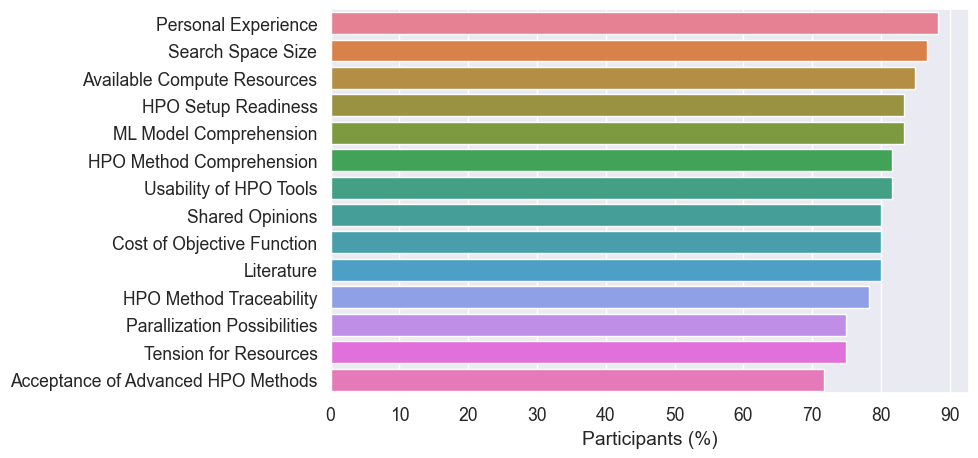

In [25]:
plt.figure(figsize=(10, 4.8))
ax = sns.barplot(considered_context_factors.sort_values("Value", ascending=False), x="Value", y="Decision Factor", hue="Decision Factor")
ax.set_ylabel(None)
ax.set_xlabel("Participants (%)")
ax.set_xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90])

plt.tight_layout()
plt.savefig("figs/i_did_consider_decision_factor_percentage.pdf")
plt.show()

## Average Importance

In [26]:
rows = []
for i in range(1, 25):
    entry = {}

    for j in range(1, 15):
        goal_method_df = df_decision_factors.filter(regex=(f"^GD{i:02d}")).dropna(
            how="all"
        )

        # Handle empty dataframe
        try:
            description_string = (
                goal_method_df.filter(regex=(f"_{j:02d}")).iloc[0, :].values[0]
            )
            factor_df = goal_method_df.drop(0).filter(regex=(f"_{j:02d}"))
        except:
            continue

        participant_array = factor_df.index
        value_array = factor_df.values

        question = re.findall("([^/]+):", description_string)[0]
        decision_factor = re.findall(": ([^/]+) \(\(", description_string)[0]

        if decision_factor == "Model Comprehension":
            decision_factor = "ML Model Comprehension"
        if decision_factor == "HP search space size":
            decision_factor = "Search Space Size"
        if decision_factor == "Usability of HPO Method":
            decision_factor = "Usability of HPO Tools"
        if decision_factor == "HPO setup readiness":
            decision_factor = "HPO Setup Readiness"
        if decision_factor == "Acceptance of Advanced Methods":
            decision_factor = "Acceptance of Advanced HPO Methods"

        for index, value in enumerate(value_array):
            # entry={'Question': question, 'Decision Factor': decision_factor, "Value": float(value), "Participant": int(participant_array[index])}
            entry = {
                "Question": question,
                "Decision Factor": decision_factor,
                "Value": value[0] if value[0] != "nan" else np.nan,
                "Participant": int(participant_array[index]),
            }
            rows.append(entry)

decision_factor_results = pd.DataFrame(rows)

<>:23: SyntaxWarning: invalid escape sequence '\('
<>:23: SyntaxWarning: invalid escape sequence '\('
C:\Users\Marc\AppData\Local\Temp\ipykernel_18532\610205188.py:23: SyntaxWarning: invalid escape sequence '\('
  decision_factor = re.findall(": ([^/]+) \(\(", description_string)[0]


In [27]:
# dropping answers labeled "nicht beantwortet"
decision_factor_results = decision_factor_results.drop(
    decision_factor_results[
        decision_factor_results["Value"] == "nicht beantwortet"
    ].index
)
decision_factor_results["Value"] = pd.to_numeric(decision_factor_results["Value"])

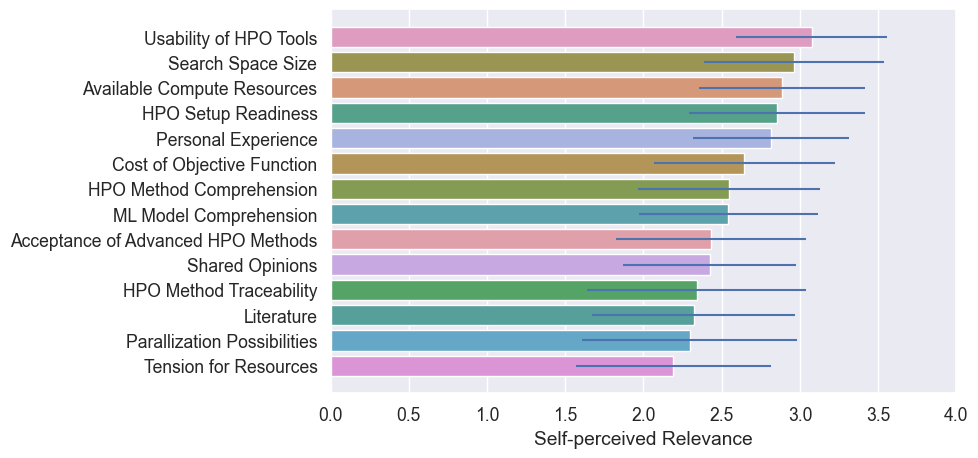

In [28]:
# decision_factor_results.groupby(["Decision Factor"]).mean().sort_values('Value')['Value'].plot(kind='bar')
tmp = (
    decision_factor_results[["Decision Factor", "Value"]]
    .groupby(["Decision Factor"])
    .mean()["Value"]
    .reset_index()
)
tmp["error"] = (
    decision_factor_results[["Decision Factor", "Value"]]
    .groupby(["Decision Factor"])
    .std()
    .reset_index()["Value"]
)
tmp["Value"] += 2
tmp2 = tmp.sort_values(by="Value", ascending=False)

plt.figure(figsize=(10, 4.8))
ax = sns.barplot(
    tmp2,
    x="Value",
    y="Decision Factor",
    hue="Decision Factor",
    legend=False,
    palette=[colors[d] for d in tmp2["Decision Factor"]],
)
ax.errorbar(x=tmp2["Value"], y=range(0, 14), xerr=tmp2["error"] / 2, fmt="none")
ax.set_ylabel(None)
ax.set_xlabel("Self-perceived Relevance")
ax.set(xlim=(0, 4))
# ax.set_xticks([-1, 0, 1])
# ax.set_xticklabels(['Low', 'Neutral', 'High'])

plt.tight_layout()
plt.savefig("figs/average_importance_decision_factors.pdf")
plt.show()

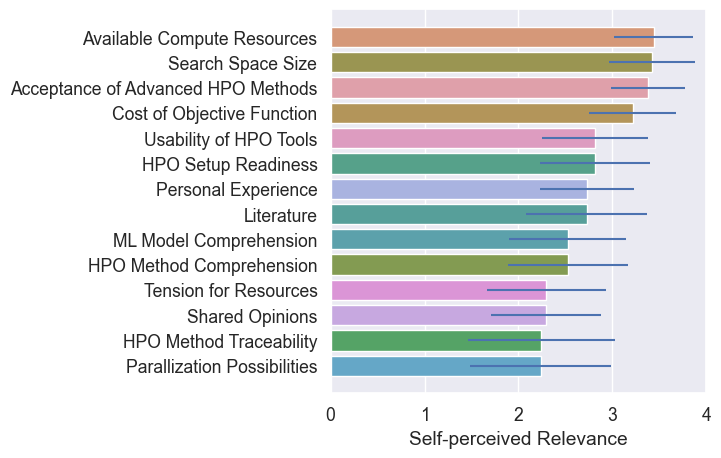

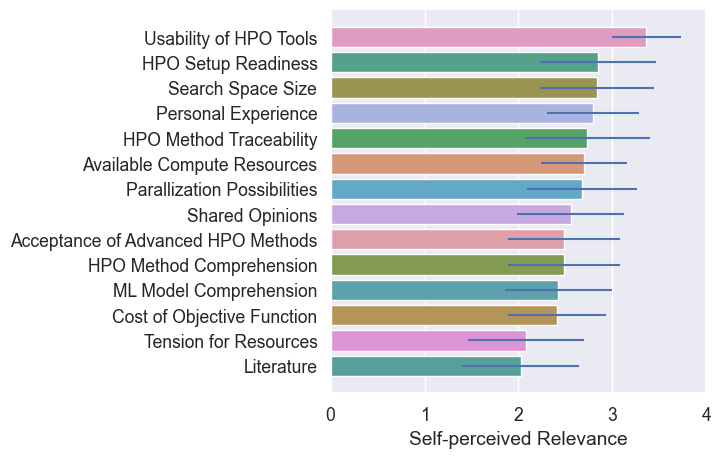

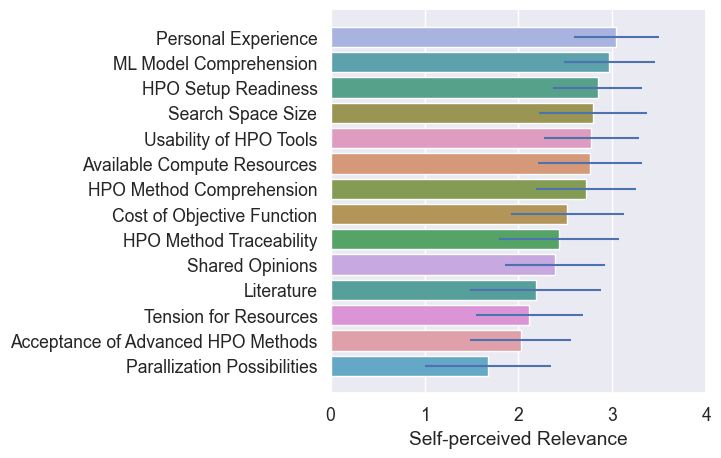

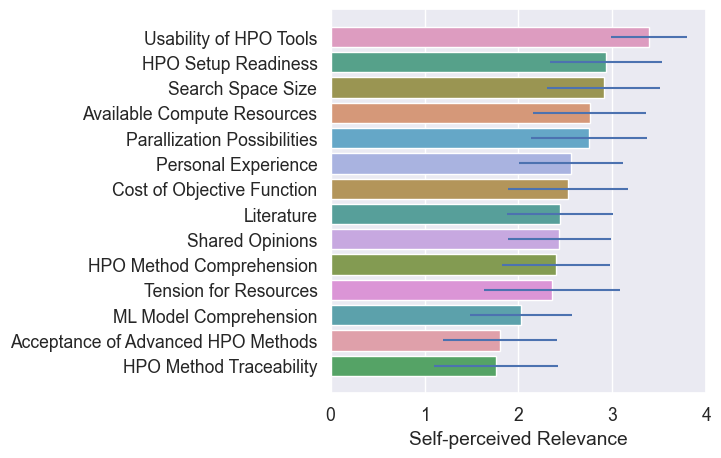

In [29]:
tmp_ = decision_factor_results
tmp_["Question"] = decision_factor_results["Question"].str[:2]

tmp = tmp_.groupby(["Question", "Decision Factor"]).mean(["Value"]).reset_index()
tmp["Value"] += 2
tmp["error"] = (
    tmp_.groupby(["Question", "Decision Factor"]).std().reset_index()["Value"]
)

for hpo in tmp["Question"].unique():
    plt.figure(figsize=(7.5, 4.8))

    tmp2 = tmp[tmp["Question"] == hpo][["Value", "Decision Factor", "error"]]
    tmp2 = tmp2.sort_values(by="Value", ascending=False)

    ax = sns.barplot(
        tmp2,
        x="Value",
        y="Decision Factor",
        hue="Decision Factor",
        legend=False,
        palette=[colors[d] for d in tmp2["Decision Factor"]],
    )
    ax.errorbar(x=tmp2["Value"], y=range(0, 14), xerr=tmp2["error"] / 2, fmt="none")
    ax.set(xlim=(0, 4))

    ax.set_ylabel(None)
    ax.set_xlabel("Self-perceived Relevance")

    plt.tight_layout()
    plt.savefig(f"figs/average_importance_decision_factors_{hpo}.pdf")
    plt.show()


# Demographics

In [30]:
df_finished = df.where(
    (df["FINISHED"] == "1")
    | (df["FINISHED"] == "Wurde die Befragung abgeschlossen (letzte Seite erreicht)?")
).dropna(subset=["FINISHED"])

In [31]:
for i in range(2, 10):
    print(df_finished.filter(regex=(f"^DE{i:02d}")).value_counts(), end="\n\n\n")

DE02             
2-4                  20
5-7                  13
<2                    8
8-10                  3
11-15                 2
> 15                  1
YearsAIExperience     1
Name: count, dtype: int64


DE03                   DE03_06                             
Academia               nan                                     11
IT Support & Services  nan                                      2
Field                  Field: Other                             1
Academia               Physics/Research                         1
Finance                nan                                      1
Other                  AI Services                              1
                       Coporate                                 1
                       E-Commerce                               1
                       First insurance then academia,           1
                       Software                                 1
                       Software development AI Applications     1


In [32]:
df_finished['DE02'].dropna().shape

(48,)

In [33]:
df_finished[f"DE03"].value_counts()

DE03
Academia                 26
IT Support & Services     9
Other                     7
Automotive                4
Field                     1
Finance                   1
Name: count, dtype: int64

In [34]:
df_finished["DE01_05"].value_counts()

DE01_05
nicht gewählt       35
ausgewählt          12
WorkFocus: Other     1
Name: count, dtype: int64